In [1]:
] activate .

  Activating environment at `~/Documents/Julia/AIDA/Project.toml`


In [2]:
using GaussianProcesses, Plots

┌ Info: Precompiling GaussianProcesses [891a1506-143c-57d2-908e-e1f8e92e6de9]
└ @ Base loading.jl:1317
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [39]:
# generate data
import Distributions
import ProgressMeter

using Random
using Plots

Random.seed!(42)

n_samples = 150

dimensionality = 2
rθ = [-0.9, 0.5]
ms = [[0.9, 0.1], [0.2, 0.8]]
σ(w, x) = 1/(1+exp(-w'x))

A_data = [0.9 0.1; 0.1 0.9] # Transition probabilities (some transitions are impossible)

s_0_data = [1.0, 0.0] # Initial state

# Generate some data
s_data = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
s_t_min_data = s_0_data
for t in 1:n_samples
    a = A_data*s_t_min_data
    s_data[t] = zeros(dimensionality); s_data[t][rand(Distributions.Categorical(a./sum(a)))] = 1.0
    s_t_min_data = s_data[t]
end
sampled_means = [ms[argmax(s_data[i])] for i in 1:n_samples]
πs = map(x -> σ(rθ, x), sampled_means)
outputs = [rand(Distributions.Bernoulli(πs[i])) for i in 1:n_samples]

150-element Vector{Bool}:
 0
 0
 0
 1
 1
 1
 0
 0
 1
 0
 1
 0
 1
 ⋮
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0
 1
 0

In [40]:
X = zeros(n_samples, dimensionality)
for (index, sample) in enumerate(sampled_means)
    X[index, :] = sample + sqrt(1e-3)*randn(dimensionality)
end
Y = outputs

150-element Vector{Bool}:
 0
 0
 0
 1
 1
 1
 0
 0
 1
 0
 1
 0
 1
 ⋮
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0
 1
 0

In [48]:
X_train, X_test = X[1:100, :], X[101:end, :]
y_train, y_test = Y[1:100], Y[101:end]

(Bool[0, 0, 0, 1, 1, 1, 0, 0, 1, 0  …  1, 0, 1, 0, 0, 1, 1, 1, 1, 1], Bool[0, 0, 0, 0, 0, 1, 1, 0, 0, 0  …  0, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [49]:
mZero = MeanZero()
kern = Matern(5/2,[0.0,0.0],0.0) + SE(0.0,0.0)

Type: SumKernel{Mat52Ard{Float64}, SEIso{Float64}}
  Type: Mat52Ard{Float64}, Params: [-0.0, -0.0, 0.0]  Type: SEIso{Float64}, Params: [0.0, 0.0]

In [50]:
gp = GP(X_train',y_train,mZero,kern,-2.0)

GP Exact object:
  Dim = 2
  Number of observations = 100
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: SumKernel{Mat52Ard{Float64}, SEIso{Float64}}
      Type: Mat52Ard{Float64}, Params: [-0.0, -0.0, 0.0]      Type: SEIso{Float64}, Params: [0.0, 0.0]
  Input observations = 
[0.9255978589160258 0.8687540465450774 … 0.23046464985787882 0.21441877824982536; 0.12460471976240228 0.0944568197712355 … 0.8154466604283955 0.7476406507523692]
  Output observations = Bool[0, 0, 0, 1, 1, 1, 0, 0, 1, 0  …  1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
  Variance of observation noise = 0.01831563888873418
  Marginal Log-Likelihood = -456.672

In [51]:
using Optim

In [52]:
optimize!(gp)

 * Status: success

 * Candidate solution
    Final objective value:     6.922385e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.05e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.42e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.84e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.11e-16 ≰ 0.0e+00
    |g(x)|                 = 7.22e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    57
    f(x) calls:    185
    ∇f(x) calls:   185


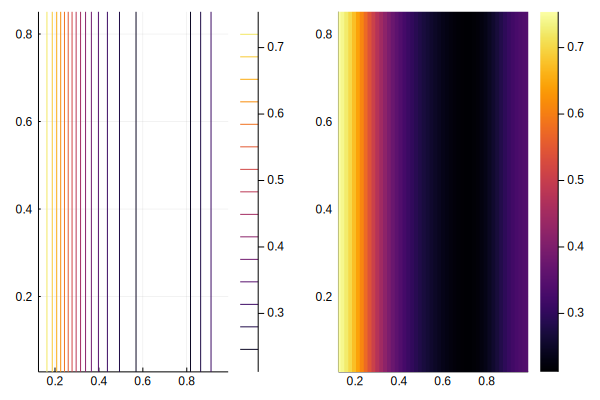

In [53]:
plot(contour(gp), heatmap(gp))

In [54]:
samples = mcmc(gp; nIter=10000, burn=1000, thin=10);

Number of iterations = 10000, Thinning = 10, Burn-in = 1000 
Step size = 0.100000, Average number of leapfrog steps = 10.012200 
Number of function calls: 100123
Acceptance rate: 0.828700 


In [62]:
ymean = Array{Float64}(undef,size(samples,2),size(X_test,1));

for i in 1:size(samples,2)
    set_params!(gp,samples[:,i])
    update_target!(gp)
    ymean[i,:] = predict_y(gp,X_test')[1]
end

In [63]:
ymean

901×50 Matrix{Float64}:
 0.621304   0.304261   0.335187  0.307241  …  0.335052  0.312814  0.299966
 0.648234   0.290376   0.304062  0.291572     0.303995  0.293851  0.288677
 0.653481   0.305861   0.278916  0.303341     0.279022  0.298473  0.309331
 0.648243   0.307458   0.269822  0.30429      0.269986  0.297943  0.311666
 0.653766   0.295373   0.298164  0.295492     0.298141  0.295759  0.295216
 0.616985   0.310071   0.340094  0.312984  …  0.339967  0.31841   0.30588
 0.651949   0.290646   0.311022  0.292468     0.310927  0.29594   0.288069
 0.648065   0.299753   0.282275  0.298206     0.282346  0.295137  0.301823
 0.664201   0.355604   0.231189  0.342295     0.231625  0.318114  0.375124
 0.659783   0.287862   0.3227    0.291252     0.322526  0.297632  0.282854
 0.661506   0.286316   0.321421  0.289773  …  0.321274  0.296182  0.281319
 0.650429   0.295306   0.328356  0.298542     0.328217  0.304554  0.290634
 0.465283   0.453369   0.45451   0.453482     0.454505  0.45369   0.453206
 ⋮

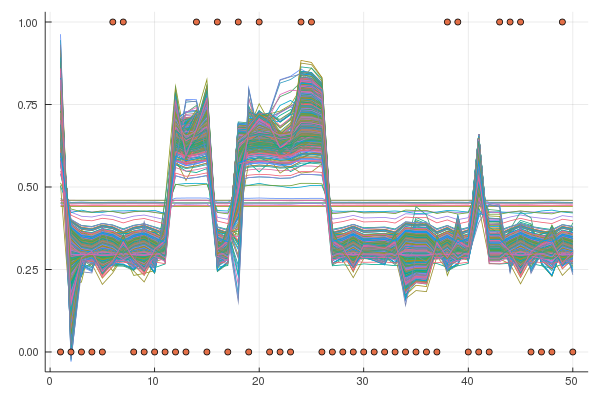

In [65]:
plot(ymean',leg=false,html_output_format=:png)
scatter!(y_test)